# Generating Infill Designs based on Forces through a Part

by James Gopsill

![](header_fig_2.png)

![center](printed_beam.jpg)


### Citation
```
@article{gopsill2017,
	doi = {10.1007/s40964-017-0034-y},
	url = {https://doi.org/10.1007%2Fs40964-017-0034-y},
	year = 2017,
	month = {nov},
	publisher = {Springer Nature},
	author = {James A. Gopsill and Jonathan Shindler and Ben J. Hicks},
	title = {Using finite element analysis to influence the infill design of fused deposition modelled parts},
	journal = {Progress in Additive Manufacturing}
}
```

In [83]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import numpy as np
import pickle
import matplotlib.pyplot as plt
import networkx as nx
from scipy import interpolate

## Loading and Interpolating the FEA Data

In [84]:
fea_data = pickle.load(open('three_point_beam.pkl', 'rb'))

print(fea_data)

print('x min:', np.min(fea_data[:,0]), 'x max:', np.max(fea_data[:,0]))
print('y min:', np.min(fea_data[:,1]), 'y max:', np.max(fea_data[:,1]))
print('z min:', np.min(fea_data[:,2]), 'z max:', np.max(fea_data[:,2]))


print('Generating Grid Data')
dx = np.arange(-50, 51, 5)
dy = np.arange(-20, 21, 5)
X, Y = np.meshgrid(dx, dy)
m = interpolate.griddata(fea_data[:,0:2], fea_data[:,3], (X, Y), method='linear')

print('Grid Data - Max:', np.max(m), ', Min:', np.min(m))

[[-50.         20.          4.          0.0630604]
 [-50.         19.3333      4.          0.082949 ]
 [-49.3333     19.3333      4.          0.143756 ]
 ..., 
 [-30.6667      8.66667     4.         37.8364   ]
 [-30.          8.          4.         38.3281   ]
 [-30.          8.66667     4.         38.0116   ]]
x min: -50.0 x max: 50.0
y min: -20.0 y max: 20.0
z min: 4.0 z max: 4.0
Generating Grid Data
Grid Data - Max: 1419.69000001 , Min: 0.0485548


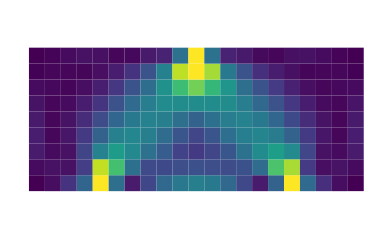

In [85]:
plt.pcolor(m, vmax=np.max(m) / 4)
plt.axis('equal')
plt.axis('off')
plt.show()

## Generating the infill network

In [86]:
g = nx.Graph()

max_stress = np.max(m)

# add nodes
for i, x in enumerate(dx):
    for j, y in enumerate(dy):
        node_name = str(x)+'_'+str(y)
        #print(node_name)
        g.add_node(node_name, x=x, y=y, stress=m[j, i])
        
print(len(dx), len(dy))
print(m.shape)

weightings = []
for x in range(1, len(dx)-1):
    for y in range(1, len(dy)-1):
        from_node = str(dx[x])+'_'+str(dy[y])
        
        # left
        to_node = str(dx[x-1])+'_'+str(dy[y])
        if not g.has_edge(from_node, to_node):
            weighting = max_stress - (m[y, x] +  m[y, x-1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)
        
        # bottom-left
        to_node = str(dx[x-1])+'_'+str(dy[y-1])
        if not g.has_edge(from_node, to_node):
            weighting = max_stress - (m[y, x] +  m[y-1, x+1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)

        # bottom
        to_node = str(dx[x])+'_'+str(dy[y-1])
        if not g.has_edge(from_node, to_node):
            weighting = max_stress - (m[y, x] +  m[y-1, x+1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)
        
        # bottom-right
        to_node = str(dx[x+1])+'_'+str(dy[y-1])
        if not g.has_edge(from_node, to_node):
            weighting = max_stress - (m[y, x] +  m[y+1, x-1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)
        
        # right
        to_node = str(dx[x+1])+'_'+str(dy[y])
        if not g.has_edge(from_node, to_node):
            weighting = max_stress - (m[y, x] +  m[y, x+1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)

        # top-right
        to_node = str(dx[x+1])+'_'+str(dy[y+1])
        if not g.has_edge(from_node, to_node):
            weighting = max_stress - (m[y, x] +  m[y+1, x+1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)

        # top
        to_node = str(dx[x])+'_'+str(dy[y+1])
        if not g.has_edge(from_node, to_node):
            weighting = max_stress - (m[y, x] +  m[y+1, x]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)
            
        # top-left
        to_node = str(dx[x-1])+'_'+str(dy[y+1])
        if not g.has_edge(from_node, to_node):
            weighting = max_stress - (m[y, x] +  m[y+1, x-1]) / 2.0
            weightings.append(weighting)
            g.add_edge(from_node, to_node, weight=weighting)

print('Weightings:', np.max(weightings))
print('Number of Nodes before pruning:', g.number_of_nodes())     

21 9
(9, 21)
Weightings: 1416.64600981
Number of Nodes before pruning: 189


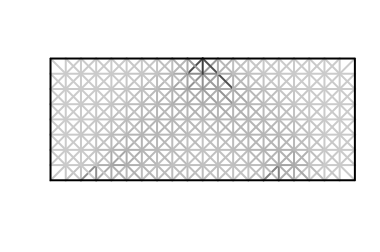

In [87]:
for u, v, data in g.edges(data=True):
    line_x = [ g.node[u]['x'], g.node[v]['x'] ]
    line_y = [ g.node[u]['y'], g.node[v]['y'] ]
    
    c = ( data['weight'] / (max_stress*1.25) )
    if c > 0.9:
        c = 0.9
    elif c < 0:
        c = 0
    
    plt.plot(line_x, line_y, '-', color=(c, c, c), linewidth=2)

plt.plot([-50, 50, 50, -50, -50],[-20, -20, 20, 20, -20], '-k', linewidth=2)
plt.xlim(-50, 50)
plt.axis('equal')
plt.axis('off')
plt.show()

## Optimising the infill placement

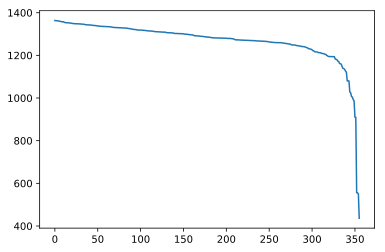

In [92]:
edge_weights = []
for u, v, d in g.edges(data=True):
    edge_weights.append(d['weight'])

edge_weights.sort(reverse=True)

plt.plot(edge_weights)
plt.show()

Cut Off Weight: 1302.53205001
Number of Edges to Remove: 142


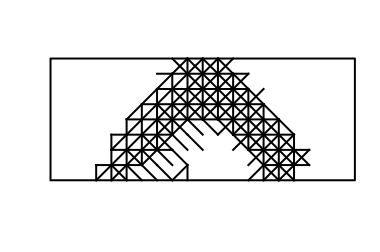

In [93]:
number_of_edges = g.number_of_edges()
# Want to have 40% of the edges
cut_off_index = int(number_of_edges * 0.4)
cut_off_weight = edge_weights[cut_off_index]
print('Cut Off Weight:', cut_off_weight)

edges_to_remove = []
for u, v, d in g.edges(data=True):
    if d['weight'] > cut_off_weight:
        edges_to_remove.append([u, v])
    
print('Number of Edges to Remove:', len(edges_to_remove))
    
for u, v in edges_to_remove:            
    g.remove_edge(u, v)
    
for u, v, data in g.edges(data=True):
    line_x = [ g.node[u]['x'], g.node[v]['x'] ]
    line_y = [ g.node[u]['y'], g.node[v]['y'] ]

    plt.plot(line_x, line_y, '-k', linewidth=2)

plt.plot([-50, 50, 50, -50, -50],[-20, -20, 20, 20, -20], '-k', linewidth=2)
plt.xlim(-50, 50)
plt.axis('equal')
plt.axis('off')
plt.show()

Iteration: 1
Iteration: 2
Iteration: 3
Number of Nodes: 74


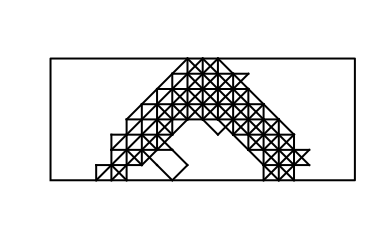

In [94]:
# check for any leftover nodes with a single degree of connection (i.e. not able to bear any load)
keep_running = True
i = 0
while keep_running:
    i = i + 1
    print('Iteration:', i)
    keep_running = False
    nodes_to_remove = []
    for u in g.nodes():
        if g.degree(u) < 2:
            nodes_to_remove.append(u)
    
    if nodes_to_remove:
        keep_running = True
        for n in nodes_to_remove:
            g.remove_node(n)
            
print('Number of Nodes:', g.number_of_nodes())

## Plotting
for u, v, data in g.edges(data=True):
    line_x = [ g.node[u]['x'], g.node[v]['x'] ]
    line_y = [ g.node[u]['y'], g.node[v]['y'] ]

    plt.plot(line_x, line_y, '-k', linewidth=2)

plt.plot([-50, 50, 50, -50, -50],[-20, -20, 20, 20, -20], '-k', linewidth=2)
plt.xlim(-50, 50)
plt.axis('equal')
plt.axis('off')
plt.show()   

# Generating the printer path